In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_letters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [4]:
SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [5]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [6]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [7]:
# GroupKFold em um pipeline com StandardScaler e SVC

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [8]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


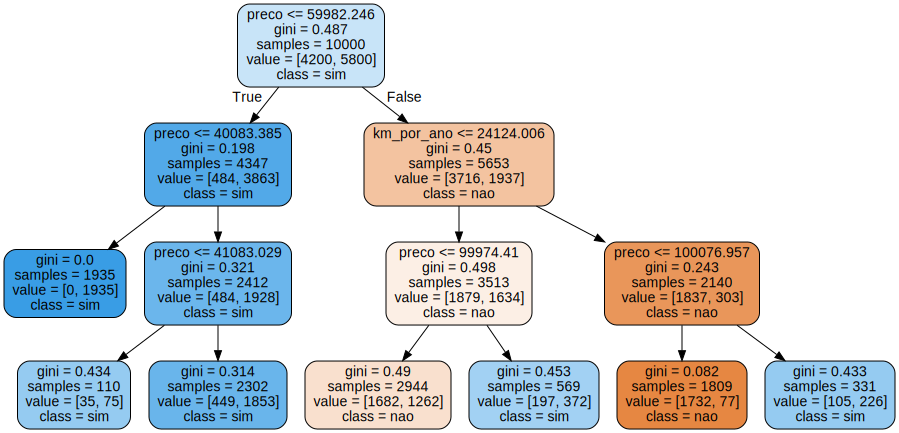

In [9]:
features = x_azar.columns
modelo = DecisionTreeClassifier(max_depth=3)
modelo.fit(x_azar, y_azar)
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                          class_names=['nao', 'sim'], feature_names=features)
graph = graphviz.Source(dot_data)
graph

In [10]:
SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=4)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.63
Intervalo [76.41, 80.86]


# Testando Hiperparametros

In [11]:
def roda_arvore(max_depth):
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    print("Arvore max_depth = %d, treino = %.2f, teste = %.2f," % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    tabela = [max_depth, train_score, test_score]

    return tabela

In [12]:
resultados = [roda_arvore(i) for i in range (1, 33)]
resultados = pd.DataFrame(resultados, columns = ["max_depth", "train", "test"])
resultados.head()

Arvore max_depth = 1, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, treino = 78.75, teste = 78.67,
Arvore max_depth = 4, treino = 78.79, teste = 78.62,
Arvore max_depth = 5, treino = 78.94, teste = 78.55,
Arvore max_depth = 6, treino = 79.17, teste = 78.12,
Arvore max_depth = 7, treino = 79.50, teste = 77.96,
Arvore max_depth = 8, treino = 79.89, teste = 77.84,
Arvore max_depth = 9, treino = 80.47, teste = 77.39,
Arvore max_depth = 10, treino = 81.17, teste = 77.17,
Arvore max_depth = 11, treino = 82.03, teste = 76.91,
Arvore max_depth = 12, treino = 82.87, teste = 76.39,
Arvore max_depth = 13, treino = 83.94, teste = 75.87,
Arvore max_depth = 14, treino = 85.02, teste = 75.61,
Arvore max_depth = 15, treino = 86.14, teste = 75.13,
Arvore max_depth = 16, treino = 87.20, teste = 75.09,
Arvore max_depth = 17, treino = 88.29, teste = 74.76,
Arvore max_depth = 18, treino = 89.28, teste = 74.28,
Arvore max_depth = 19, treino = 90.36

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.622712
4,5,78.941007,78.545822


<AxesSubplot:xlabel='max_depth', ylabel='train'>

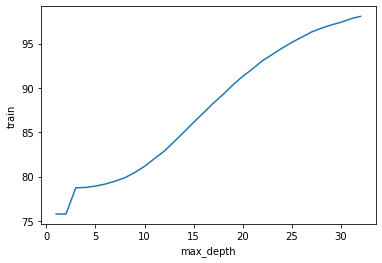

In [13]:
sns.lineplot(x = "max_depth", y = "train", data = resultados)

<AxesSubplot:xlabel='max_depth', ylabel='test'>

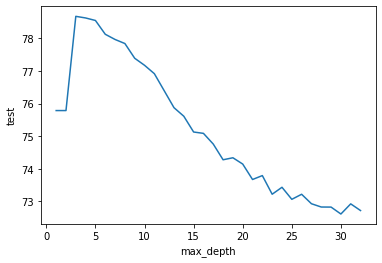

In [14]:
sns.lineplot(x = "max_depth", y = "test", data = resultados)

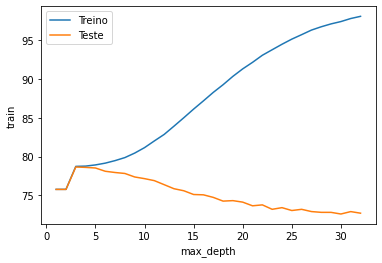

In [15]:
sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(['Treino', 'Teste'])

In [16]:
resultados.sort_values('test', ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.622712
4,5,78.941007,78.545822
5,6,79.170115,78.123266
6,7,79.495696,77.963185


# Explorando Hiperparametros em duas dimensoes

In [17]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256, 512]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth =

Arvore max_depth = 22, min_samples_leaf = 256, treino = 78.90, teste = 77.85
Arvore max_depth = 22, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 23, min_samples_leaf = 32, treino = 80.88, teste = 76.87
Arvore max_depth = 23, min_samples_leaf = 64, treino = 79.79, teste = 77.30
Arvore max_depth = 23, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 23, min_samples_leaf = 256, treino = 78.90, teste = 77.85
Arvore max_depth = 23, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 24, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 24, min_samples_leaf = 64, treino = 79.79, teste = 77.30
Arvore max_depth = 24, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 24, min_samples_leaf = 256, treino = 78.90, teste = 77.85
Arvore max_depth = 24, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 25, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvo

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,1,512,75.791169,75.784219


In [18]:
resultados.sort_values('test', ascending=False).head()

,max_depth,min_samples_leaf,train,test
16,4,64,78.750993,78.672633
15,4,32,78.750993,78.672633
18,4,256,78.750993,78.672633
17,4,128,78.750993,78.672633
10,3,32,78.750993,78.672633


In [19]:
corr = resultados.corr()

<AxesSubplot:>

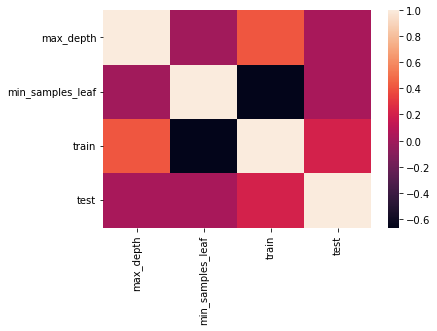

In [20]:
sns.heatmap(corr)

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='train', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='test', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='train'>,
        <AxesSubplot:xlabel='train', ylabel='train'>,
        <AxesSubplot:xlabel='test', ylabel='train'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='test'>,
        <AxesSubplot:xlabel='train', ylabel='test'>,
        <AxesSubplot:xlabel='test', ylabel='test'>]], dtype=object)

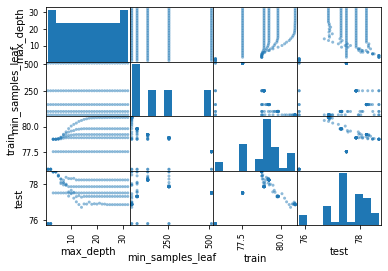

In [21]:
scatter_matrix(resultados)

C:\Users\BRUNOR~1\AppData\Local\Temp/ipykernel_11632/1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

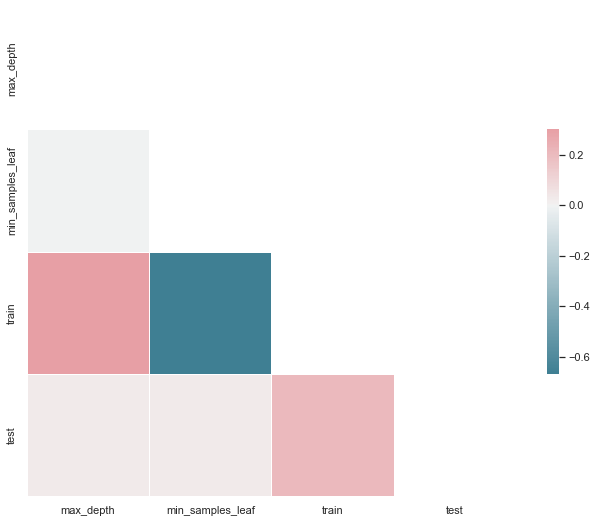

In [22]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()

  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        for min_samples_split in [32, 64, 128, 256]:
          tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
          resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split",
                                                  "train","test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.009281,0.002457
1,1,32,64,75.791169,75.784219,0.009948,0.001494
2,1,32,128,75.791169,75.784219,0.009113,0.004624
3,1,32,256,75.791169,75.784219,0.010373,0.003274
4,1,64,32,75.791169,75.784219,0.009195,0.002516


C:\Users\BRUNOR~1\AppData\Local\Temp/ipykernel_11632/1709128675.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

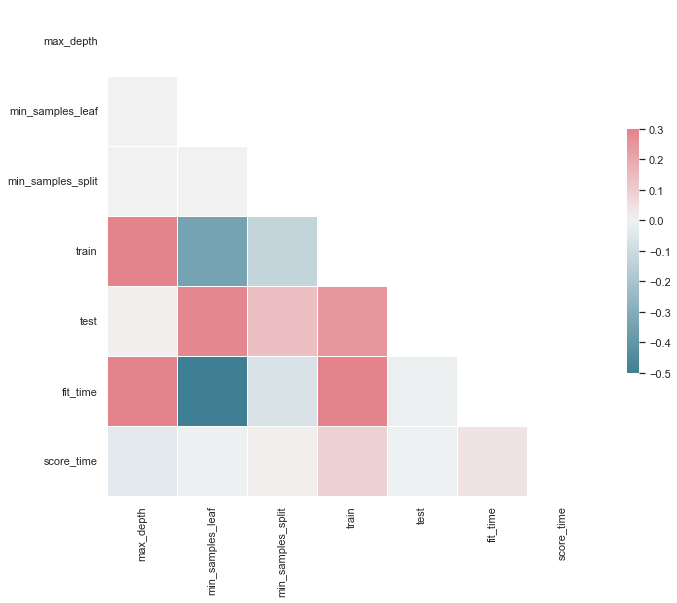

In [24]:
corr = resultados.corr()
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [25]:
resultados.sort_values('test', ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.019786,0.003971
48,4,32,32,78.750993,78.672633,0.022022,0.002398
34,3,32,128,78.750993,78.672633,0.018408,0.001540
35,3,32,256,78.750993,78.672633,0.018141,0.002999
36,3,64,32,78.750993,78.672633,0.017562,0.003707


# Explorando Hiperparametros com GridSearchCV

In [26]:
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [27]:
espaco_de_parametros = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128, 256],
    'min_samples_leaf': [32, 64, 128, 256],
    'criterion': ['gini', 'entropy']
}
busca = GridSearchCV(DecisionTreeClassifier(), 
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits=10))
busca.fit(x_azar, y_azar, groups=dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018952,0.002259,0.003397,0.003508,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.019152,0.003184,0.002163,0.002406,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.018557,0.003071,0.001401,0.002180,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.018235,0.002321,0.001423,0.002314,gini,3,32,256,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.016763,0.002637,0.003851,0.003308,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [28]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [29]:
melhor = busca.best_estimator_
predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar) * 100
print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


# Como ter uma estimativa sem vicio nos dados
cross validation com o melhor

In [30]:
from sklearn.model_selection import cross_val_score

cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10),
               groups=dados.modelo)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 841, in fit
    self._run_search(evaluate_candidates)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1296, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 807, in evaluate_candidates
    (spli

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [35]:
from sklearn.model_selection import KFold
espaco_de_parametros = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128, 256],
    'min_samples_leaf': [32, 64, 128, 256],
    'criterion': ['gini', 'entropy']
}
busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019080,0.003405,0.003712,0.003715,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.775,0.7865,0.802,0.7955,0.7765,0.7871,0.010504,1
1,0.016152,0.000307,0.001599,0.003199,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.775,0.7865,0.802,0.7955,0.7765,0.7871,0.010504,1
2,0.014465,0.003091,0.003309,0.004055,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.775,0.7865,0.802,0.7955,0.7765,0.7871,0.010504,1
3,0.016021,0.000044,0.003199,0.003918,gini,3,32,256,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.775,0.7865,0.802,0.7955,0.7765,0.7871,0.010504,1
4,0.014623,0.003340,0.003205,0.003925,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.775,0.7865,0.802,0.7955,0.7765,0.7871,0.010504,1


In [36]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.71000000000001


In [38]:
cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True),
               groups=dados.modelo)

array([0.7805, 0.771 , 0.793 , 0.796 , 0.7915])

In [40]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))
score = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True),
               groups=dados.modelo)
imprime_score(score)

Accuracy médio 78.70
Intervalo [76.59, 80.81]


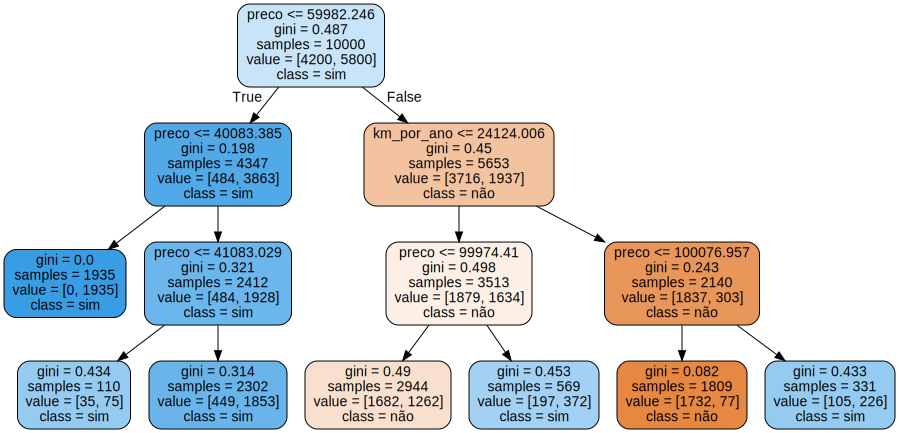

In [41]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
graph = graphviz.Source(dot_data)
graph